# GCNNによる隣接行列の分類

## Colabで実行するときの設定

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from scipy.io import mmread
from sklearn.model_selection import train_test_split
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_scatter import  scatter

# random seed
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## データの用意

### データの読み込み

In [5]:
test_run = True

#データの読み込み
if test_run:
    # プログラムが動くかどうかのテスト用の小さいデータ．shape=（5*9, 32*32 + 1）
    adjMats = mmread("small_adjMats.mtx").toarray()
    targets = mmread("small_targets.mtx")
    epoch_num = 1
    batch_size = 128
else:
    # 本番用データ
    adjMats = mmread("adjMats.mtx").toarray()
    targets = mmread("targets.mtx")
    epoch_num = 100
    batch_size = 128

nBeads = int(np.sqrt(adjMats.shape[1]))

# vggを使うためデータのshapeを(nSmaple*9, 1, nBeads,nBeads)にする.第2次元はチャネル数に相当する．
#adjMats = adjMats.reshape(adjMats.shape[0], 1, nBeads, nBeads)
adjMats = adjMats.reshape(adjMats.shape[0], nBeads, nBeads)


### (dataset,) dataloaderの作成

In [6]:
# PyG用のデータに変換

# とりあえずはPyGのDataset, In Memory Datasetを使わない簡易的な実装を用いる
data_list = []
for i, a in enumerate(adjMats):
    e_index = np.where(a > 0)

    # edge_weightを使うときはなぜか入力をfloatにしておかないとエラーになる
    x = torch.ones((nBeads, 1)).float()  # ノードに特徴量はないのでとりあえず1にしている

    edge_index = torch.tensor(e_index, dtype=torch.long)

    # edge_weightを使うときはなぜか入力をfloatにしておかないとエラーになる
    edge_attr = torch.tensor(a[e_index].reshape(-1,1)).float()

    y = int(targets[i]) - 1  ##pytorchではカテゴリは1th indexではなく0th indexでなければならない

    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

test_size = int(len(data_list) * 0.1)

trainval_list, test_list = train_test_split(data_list, test_size=test_size, shuffle=True)
train_list, val_list = train_test_split(trainval_list, test_size=test_size, random_state=0)

# dataloaderの作成    
train_loader = DataLoader(train_list, batch_size=batch_size)
val_loader = DataLoader(val_list, batch_size=batch_size)
test_loader = DataLoader(test_list, batch_size=batch_size)

## モデルの定義

### ネットワークの定義

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: 入力グラフのチャネル数への依存をなくす
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.conv5 = GCNConv(64, 96)
        self.conv6 = GCNConv(96, 128)
        self.linear1 = torch.nn.Linear(128,64)
        #TODO: 分類数への依存をなくす
        self.linear2 = torch.nn.Linear(64,9)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        """
        #edge_weightを用いる場合はこちらを用いる
        #edge_weight = data.edge_attr うまくいかない．PyG自体のバグ？
        edge_weight = torch.squeeze(data.edge_attr)
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv6(x, edge_index, edge_weight)
        x = F.relu(x)
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        
        x = scatter(x, data.batch, dim=0, reduce="max")
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

### 学習

In [8]:
start = time.time()
# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

train_size = len(train_list)
val_size = len(val_list)
test_size = len(test_list)

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

model.train()
for epoch in range(epoch_num):
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        train_total += batch.y.size(0)
        train_correct += (predicted == batch.y).sum().cpu().item()

        train_loss += loss.cpu().item()
        if i % 10 == 9:
            progress_bar = '['+('='*((i+1)//10))+(' '*((train_size//100-(i+1))//10))+']'
            print('\repoch: {:d} loss: {:.3f}  {}'
                .format(
                    epoch + 1,
                    loss.cpu().item(),
                    progress_bar),
                end="  ")

    train_acc = float(train_correct/train_total)

    print('\repoch: {:d} loss: {:.3f}'
        .format(epoch + 1, train_loss / (train_size / batch_size)), end="  ")
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss / (train_size / batch_size))

    correct = 0
    total = 0
    batch_num = 0
    loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss += criterion(outputs,data.y)
            _, predicted = torch.max(outputs, 1)
            total += data.y.size(0)
            batch_num += 1
            correct += (predicted == data.y).sum().cpu().item()

    history["val_acc"].append(correct/total)
    history["val_loss"].append(loss.cpu().item()/batch_num)
    endstr = ' '*max(1,(train_size//1000-39))+"\n"
    print('Val Accuracy: {:.2f} %'.format(100 * float(correct/total)), end='  ')
    print(f'Val Loss: {loss.cpu().item()/batch_num:.3f}',end=endstr)

print('Finished Training')
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))


#テストデータでの最終結果出力
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().cpu().item()
print('Test Accuracy: {:.2f} %'.format(100 * float(correct/total)))

device: cpu
epoch: 1 loss: 2.350  Val Accuracy: 13.33 %  Val Loss: 2.194 
Finished Training
elapsed time: 0:00:35
Test Accuracy: 6.67 %


## 可視化

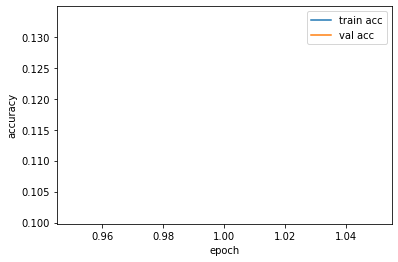

In [9]:
plt.xlabel("epoch")
plt.ylabel("accuracy")

x = np.arange(epoch_num) + 1
plt.plot(x, history["train_acc"], label="train acc")
plt.plot(x, history["val_acc"], label="val acc")
plt.legend()
plt.show()

## 実験条件

In [10]:
nSmaples = len(adjMats)
t = 20

print("=====Simulation conditions=====")
print("目的：隣接町列を生成した数字の予測")
print("ネットワーク：GCNN")
print("Test run: {}".format(test_run))
print("Number of beads: {}".format(nBeads))
print("Number of samples for each shape: {}".format(nSmaples))
print("Number of epochs: {}".format(epoch_num))
print("Batch size: {}".format(batch_size))
print("Diffusion time: {}".format(t))

print("=====Results=====")
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))
print('Test Accuracy: {:.2f} %'.format(100 * float(correct/total)))

=====Simulation conditions=====
目的：隣接町列を生成した数字の予測
ネットワーク：GCNN
Test run: True
Number of beads: 50
Number of samples for each shape: 900
Number of epochs: 1
Batch size: 128
Diffusion time: 20
=====Results=====
elapsed time: 0:00:35
Test Accuracy: 6.67 %
